# Estimating the quantiles of a varying mixture weight model

Margaux Thorez

## 1- Contextualisation

In order to monitor absenteeism in a company or professional sector, several indicators can be taken into account. In addition to analyzing the average duration of sick leaves, an interesting indicator for understanding absenteeism is the median duration.  Indeed, median analysis is more robust than mean analysis, especially in the case of extreme values that may be present at one end of the distribution. 

Now that we've presented our variable-weight mixture estimators, and compared the estimators of the survival functions of Ryzhov and Maiboroda. We now turn our attention to estimating the median duration for variable-weight mixture models.

For $q \in ]0;1[$, the $q^{th}$ quantile of a random variable $X$ with distribution function $F$ can be defined using the generalized inverse function
$$\mu_{q} \equiv F^{-1} (q) = \inf\left\{ x | F(x) \geq q \right\}.$$

The median survival time is the time $\mu_{0.5}$ for which the probability of survival is 0.5, i.e. $S(\mu_{0.5})=0.5$. In some cases, the time $\mu_{0.5}$ is not unique or does not exist. In these cases, the generalized inverse function must be used. The median is then the value $\mu := \inf\{ t : S(t) \leq 0.5\}$. For estimation, the survival function is replaced by the estimator $\hat{S}_1(t)$ and we have $\inf\{ t : \hat{F}_1(t) \geq 0.5 \} = \inf\{ t : \hat{S}_1(t) \leq 0.5\}$. 

Let $q \in ]0;1[$ and $\mu_q$ be the quantile of order $q$ of group 1. Let be the Ryzhov model. We assume that the probability density of class 1 is a continuous function at the point $\mu_q$ and such that $f_1(\mu_q) > 0$. We have shown that 

$$ W_n\left(\hat{\mu}_q - \mu_q\right) \xrightarrow[n \rightarrow +\infty ]{\mathcal{L}} \mathcal{N}(0,1),$$

with $W_n = \frac{\sqrt{n}}{\sigma_{AB}} \mbox{ and } \sigma_{AB}^2 = \frac{1}{f_1(\mu_q)^2}\left(\frac{a_1(A)^2}{\alpha}F_A(\mu_q)\left(1 - F_A(\mu_q)\right) + \frac{a_1(B)^2}{\beta}F_B(\mu_q)\left(1 - F_B(\mu_q)\right)\right)$. 

We will illustrate this result with a few simulations.

## 2- Libraries import

In [1]:
#Libraries import
#Basic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from scipy import stats
import random
import statistics
import seaborn as sns

#scikit-survival Kaplan-Meier estimator
from sksurv.nonparametric import kaplan_meier_estimator

#Interpolation
from scipy.interpolate import interp1d

#CVXPY for convex optimization problems.
import cvxpy as cp

#Numba import
from numba import njit, vectorize

#Parallelization modules
from sklearn.utils._joblib import Parallel, delayed

#Kolmogorov-Smirnov Test
from scipy.stats import ks_2samp
from scipy.stats import kstest

#Normality Test
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import norm

import statsmodels.stats.diagnostic

#Notebook
from jyquickhelper import add_notebook_menu
import warnings
warnings.filterwarnings('ignore')

In [41]:
add_notebook_menu()

## 3- Optimized functions

For the law parameter choice, we have to choose the parameter "law" among "exponnential", "pareto", "weibull" and "gamma"

### Survival functions

In [3]:
#Survival functions : returns the survival function of a mixture model for a certain law
def S(x,P1,P2,law,lambd1,lambd2):
    if law == "exponnential":
        S = P1*stats.expon.sf(x, scale=lambd1) + P2*stats.expon.sf(x, scale=lambd2)
    if law == "pareto":
        #Certain parameters of the Pareto law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.pareto.sf(x, b=3, loc = -(2/3)*lambd1, scale=(2/3)*lambd1) + P2*stats.pareto.sf(x, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)
    if law == "weibull":
        #Certain parameters of the Weibull law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.weibull_min.sf(x, c=2, scale=lambd1) + P2*stats.weibull_min.sf(x, c=2, scale=lambd2)
    if law == "gamma":
        S = P1*stats.gamma.sf(x, a=lambd1) + P2*stats.gamma.sf(x, a=lambd2)
    return(S)

### Simulation functions

In [4]:
#Function that creates the base sample in a mixture according to the chosen law
def InitializeMatriceX(law, lambd1, lambd2, P_1, size):
    #Matrices X_A1 and X_A2
    if law == "exponnential":
        X_1 = stats.expon.rvs(scale=lambd1, size=size)
        X_2 = stats.expon.rvs(scale=lambd2, size=size)
    if law == "pareto":
        X_1_v1 = stats.pareto.rvs(b=3, size=size)
        X_1 = (2/3)*lambd1*(X_1_v1-1)
        X_2_v1 = stats.pareto.rvs(b=3, size=size)
        X_2 = (2/3)*lambd2*(X_2_v1-1)
    if law == "weibull":
        X_1 = stats.weibull_min.rvs(c=2, scale=lambd1, size=size)
        X_2 = stats.weibull_min.rvs(c=2, scale=lambd2, size=size)    
    if law == "gamma" :
        X_1 = stats.gamma.rvs(a=lambd1, size=size)
        X_2 = stats.gamma.rvs(a=lambd2, size=size)
    #Matrice RA
    R = stats.bernoulli.rvs(P_1, size=size)
    X = R*X_1 + (1-R)*X_2
    return X

In [5]:
#Function to include censorship
@njit #(parallel=True)
def Y_ind_Allocation(Y_ind, Y, C, X):
    for i in range(len(X)):
        if Y[i]<C[i]: 
            Y_ind[i]=True
    return Y_ind

In [6]:
#Function to interpolate survival functions
def S_est_Actualisation(S_est, time, time1, t):
    S_est_res = np.concatenate(([1], S_est,[0]))
    f = interp1d(np.concatenate(([0], time,[t])), S_est_res)
    S_est_res = f(time1)
    return S_est_res

### Kaplan-Meier function of Maiboroda

In [7]:
#Function to count S_X and N_X variables for Maiboroda's estimator
@njit #(parallel=True)
def S_x_N_x_Allocation(Y,Y_ind,X_X,time):
    S_X = np.zeros_like(time)
    N_X = np.zeros_like(time)
    for k, t_k in enumerate(time):
        for i, Y_i in enumerate(Y):
            if Y_i >= t_k:
                S_X[k] += X_X[i]
            if (Y_i <= t_k) and  (Y_ind[i]==True) : 
                N_X[k] += X_X[i]
    return S_X, N_X

In [8]:
#Function to determine Maiboroda's estimator having S_X and N_X
@njit #(parallel=True)
def S_1_mx_Allocation(Y, S_X, N_X, time):
    # Initialisation
    S_1_mx = np.ones_like(time)
    for k, t_k in enumerate(time):
        for i in range(1,k):
            if (Y[i] <= t_k) and (S_X[i] != 0) :
                S_1_mx[k] = S_1_mx[k] * (1 - (N_X[i] - N_X[i-1])/S_X[i])
    return S_1_mx

In [9]:
#Function to smooth a survival function
@njit #(parallel=True)
# direction = 0 or 1
def S_1_est_mx_Threshold(S_1_est_mx, direction):
    S1_res = np.zeros_like(S_1_est_mx)
    #Maximum at 1 and minimum at 0 for the survival function
    for i, item in enumerate(S_1_est_mx):
        if item > 1 :
            S1_res[i] = 1
        elif item < 0 :
            S1_res[i] = 0
        else :
            S1_res[i] = item
    #If direction = 0, we give to S[t] the value of S[t+1] if S[t]<S[t+1]
    if direction == 0 : 
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k<len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[i] = S1_res[k]
                k+=1
    #If direction = 1, we give to S[t+1] the value of S[t] if S[t]<S[t+1]
    elif direction == 1 :
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k < len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[k] = S1_res[i]
                k+=1
    return S1_res

In [10]:
#Maiboroda's Kaplan-Meier estimator
@njit #(parallel=True)
def kaplan_meier_mx (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    return S_1_est_mx 

In [11]:
#Maiboroda's Kaplan-Meier estimator smoothed
@njit #(parallel=True)
def kaplan_meier_mx_smoothed (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    #S_1_est_mx thresholding
    S_1_est_mx_res = S_1_est_mx_Threshold(S_1_est_mx, direction)
    #Return S_1_est_mx_res if we want the survival function to be linearized, S_1_est_mx otherwise
    return S_1_est_mx_res 

## 4- Initial analysis

In [12]:
def RunSimulation(nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, S, M_inv, X_1, X_2, direction):
    ## Ryzhov
    #Initialization of matrices X_A and X_B
    X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    #Ryzhov
    C_A = stats.expon.rvs(scale=lambdC, size=nA)
    C_B = stats.expon.rvs(scale=lambdC, size=nB)
    #Independent copy of X_A and X_B
    Y_A = X_A
    Y_B = X_B
    #Initialisation of Y_A_ind and Y_B_ind
    Y_A_ind = np.full(shape=Y_A.shape, fill_value=False)
    Y_B_ind = np.full(shape=Y_B.shape, fill_value=False)
    #Actualisation of Y_A_ind and Y_B_ind
    Y_A = np.minimum(C_A, X_A)
    Y_A_ind = Y_ind_Allocation(Y_ind=Y_A_ind, Y=Y_A, C=C_A, X=X_A)
    Y_B = np.minimum(C_B, X_B)
    Y_B_ind = Y_ind_Allocation(Y_ind=Y_B_ind, Y=Y_B, C=C_B, X=X_B)
    #Kaplan Meier's estimator
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    #Initialisation of time1, t and M_inv
    time1 = np.concatenate(([0],time_A, time_B))
    time1.sort()
    t=max(time_A[-1],time_B[-1])
    #Interpolate of survival functions
    S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
    S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
    #Determination and smoothing of S_1 and S_2
    S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
    S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est
    S_1_est = S_1_est_mx_Threshold(S_1_est, direction)
    S_2_est = S_1_est_mx_Threshold(S_2_est, direction)
    ## Maiboroda
    #Initialization of matrices X, C, Y and Y_ind
    X = np.concatenate((X_A,X_B))  
    C = np.concatenate((C_A,C_B)) 
    Y = X
    Y_ind = np.full(shape=Y.shape, fill_value=False)
    #Actualisation of Y_ind
    Y = np.minimum(C, X)
    Y_ind = Y_ind_Allocation(Y_ind=Y_ind, Y=Y, C=C, X=X)
    m = Y.argsort()
    Y = Y[m]
    #Kaplan Meier's estimator
    time2, S_est = kaplan_meier_estimator(Y_ind, Y)
    #Construction of S_mx using the Kaplan Meier estimator
    S_1_mx = kaplan_meier_mx(Y=Y,Y_ind=Y_ind,X_X=X_1[m],time=time2, direction=direction)
    S_2_mx = kaplan_meier_mx(Y=Y,Y_ind=Y_ind,X_X=X_2[m],time=time2, direction=direction)
    
    #Ryzhov's estimator median
    i = 0
    while S_1_est[i] > 0.5:
        i+=1  
    result_Ryzhov = time1[i-1] 
    #Maiboroda's estimator median
    j = 0
    while S_1_mx[j] > 0.5:
        j+=1
    result_Maiboroda = time2[j-1] 

    return (result_Ryzhov, result_Maiboroda)

In [13]:
def RunParallelSimulation(nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, S, M_inv, X_1, X_2, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    
    # Initialisation des paramètres de parallélisation
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    # Entrainement de l'Estimateur sur les différentes observations de Train
    ComputedBlocks = ParallelSetUp([delayed(RunSimulation)(nA=nA, nB=nB, lambd1=lambd1, lambd2=lambd2, lambdC=lambdC, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2,S=S, M_inv=M_inv, X_1=X_1, X_2=X_2, direction = direction) for k in range(K)])

    # Concaténation en Array
    List_Ryzhov = np.array([result_Ryzhov for result_Ryzhov, _   in ComputedBlocks], dtype=np.dtype(object)) # peut etre que dtype array est approprié
    List_Maiboroda = np.array([result_Maiboroda for _, result_Maiboroda  in ComputedBlocks], dtype=np.dtype(object)) # peut etre que dtype array est approprié
  
    #return ComputedBlocks
    return List_Ryzhov, List_Maiboroda 

In [14]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

epsilon = 0
sens = 1

#Mixture parameters
lambd1 = 50
lambd2 = 30

lambdC = 1000

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1

#Quantile (between 0 and 1)
p = 0.5

#Theoretical values 
med_1 = lambd1*np.log(2)
med_2 = lambd2*np.log(2)

In [15]:
#Ryzhov :
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)
#Maiboroda :
X_1 = [2*M_inv[0][0] for i in range(0,nA)] + [2*M_inv[0][1] for i in range(0,nB)]
X_2 = [2*M_inv[1][0] for i in range(0,nA)] + [2*M_inv[1][1] for i in range(0,nB)]
X_1 = np.array(X_1)
X_2 = np.array(X_2)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


In [16]:
RunSimulation(nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, S, M_inv, X_1, X_2, sens)

(34.09533439382592, 33.77744493558445)

In [17]:
#Number of repetitions
K = 1000

In [18]:
List_Ryzhov, List_Maiboroda = RunParallelSimulation(nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, S, M_inv, X_1, X_2, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')

In [19]:
List_Ryzhov = List_Ryzhov.tolist()
List_Maiboroda = List_Maiboroda.tolist()

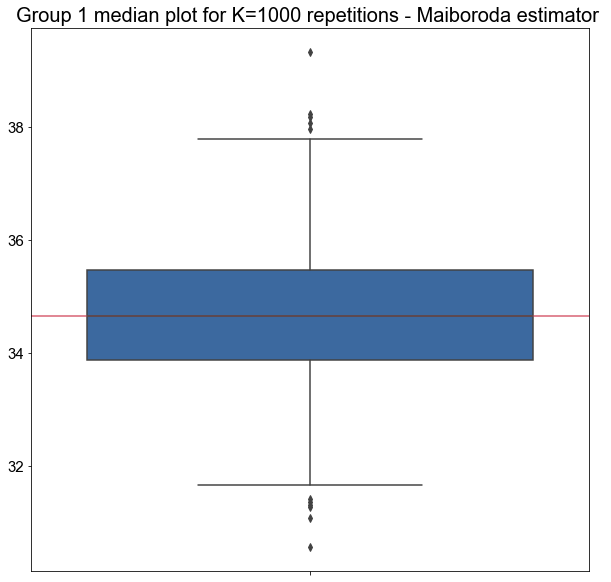

In [20]:
#Boxplot
fig = plt.figure(figsize =(10, 10))
# Creating plot
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
sns.set(style="whitegrid")
sns.boxplot(y=List_Ryzhov, color='#2C67AF')
plt.axhline(y=lambd1*np.log(2),c='#D86173')
#Show plot
plt.title('Group 1 median plot for K=1000 repetitions - Maiboroda estimator ', fontsize = 20)
plt.show()


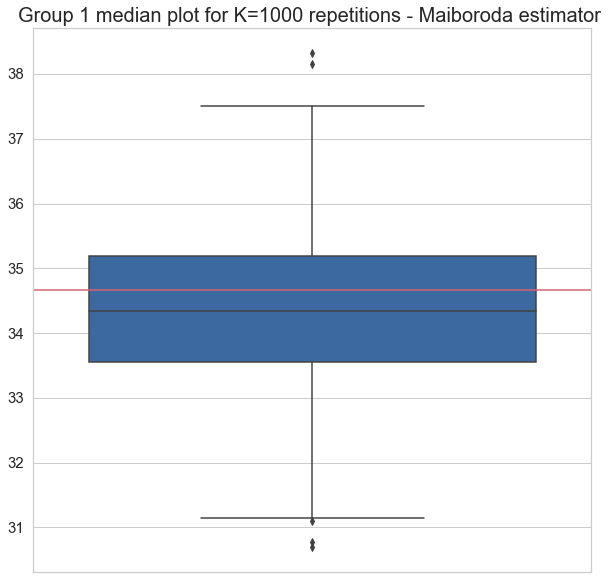

In [21]:
#Boxplot
fig = plt.figure(figsize =(10, 10))
# Creating plot
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
sns.set(style="whitegrid")
sns.boxplot(y=List_Maiboroda, color='#2C67AF')
plt.axhline(y=lambd1*np.log(2),c='#D86173')
#Show plot
plt.title('Group 1 median plot for K=1000 repetitions - Maiboroda estimator ', fontsize = 20)
plt.show()

## 5- M-estimator without censorship 

In [22]:
def RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction, p):
    #The model argument can be either "Ryzhov" or "Maiboroda"
    P = np.array([[P_A1, P_A2], [P_B1, P_B2]])
    #Samples
    X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    
    #Kaplan-Meier estimators
    Y_A = X_A
    Y_A_ind = [True for i in range(len(Y_A))]   
    Y_B = X_B
    Y_B_ind = [True for i in range(len(Y_B))]

    #Kaplan-Meier estimator
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    #Initialization of time1, t and M_inv
    time1 = np.concatenate(([0],time_A, time_B))
    time1.sort()
    t=max(time_A[-1],time_B[-1])
    #Interpolation of S_A_est and S_B_est
    S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
    S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
    #Determination of S_1_est and S_2_est (following Ryzhov's method)
    S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
    S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est
       
    #Kaplan-Meier
    X = np.concatenate((X_A,X_B))  
    Y = X
    Y_ind = [True for i in range(len(Y))]
    
    #Sorting Y
    m = Y.argsort()
    Y = Y[m]
    time, S_est = kaplan_meier_estimator(Y_ind, Y)
    time = np.concatenate(([0], time))
    S_est = np.concatenate(([1], S_est))
    
    #Maiboroda's coefficients
    if nA == nB:
        #This method can be use when na = nB
        X_1 = [2*M_inv[0][0] for i in range(0,nA)] + [2*M_inv[0][1] for i in range(0,nB)]
        X_2 = [2*M_inv[1][0] for i in range(0,nA)] + [2*M_inv[1][1] for i in range(0,nB)]
        X_1 = np.array(X_1)
        X_2 = np.array(X_2)
    else : 
        #This method is more time-consuming but is true in the general case. 
        prob_X1 = [P_A1 for i in range(0,n1)] + [P_B1 for i in range(0,n2)]
        prob_X2 = [P_A2 for i in range(0,n1)] + [P_B2 for i in range(0,n2)]
        A = np.asmatrix([prob_X1,prob_X2])
        A_trans = np.transpose(A)
        N = A.shape[1]
        X = cp.Variable(N)
        prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [n , 0] ])
        prob.solve(solver = cp.SCS, verbose=True)
        X_1 = X.value
        N = A.shape[1]
        X = cp.Variable(N)
        prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [0 , n] ])  
        prob.solve(solver = cp.SCS, verbose=True)
        X_2 = X.value
        X_1 = np.array(X_1)
        X_2 = np.array(X_2)

    #Construction of S_mx using our Kaplan Meier estimator 
    S_1_mx = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_1[m],time=time1, direction=direction)
    S_2_mx = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_2[m],time=time1, direction=direction)
    
    if model == "Ryzhov":
        S_1_est = S_1_est 
        S_2_est = S_2_est 
    elif model =="Maiboroda":
        S_1_est = S_1_mx
        S_2_est = S_2_mx
    else :
        print("Please, select a valid model")
        
    S_1_est = S_1_est_mx_Threshold(S_1_est, direction=direction)
    S_2_est = S_1_est_mx_Threshold(S_2_est, direction=direction)
    
    #Auxiliary variables
    n = nA + nB
    n1 = nA*P_A1 + nB*P_B1
    n2 = nA*P_A2 + nB*P_B2   
    alpha = nA/n
    beta = nB/n
    
    #Theorical medians
    med_1 = lambd1*np.log(2)
    med_2 = lambd2*np.log(2)
    
    #Finding the p_th quantile for group 1
    i = 0
    while S_1_est[i] > p:
        i+=1
    res1 = time1[i-1]
    
    sAB1 = (((M_inv[0][0])**2)*(S_A_est[i-1])*(1 - S_A_est[i-1]))/alpha + (((M_inv[0][1])**2)*(S_B_est[i-1])*(1 - S_B_est[i-1]))/beta  
    f1 = M_inv[0][0]*stats.expon.pdf(med_1, scale=lambd1) + M_inv[0][1]*stats.expon.pdf(med_1, scale=lambd2) 
    result_1 = (sqrt(n)*(res1 - med_1))/sqrt(sAB1/f1**2)
    
    #Finding the p_th quantile for group 2
    i = 0
    while S_2_est[i] > p:
        i+=1
    res2 = time1[i-1]
    
    sAB2 = (((M_inv[1][0])**2)*(S_A_est[i-1])*(1 - S_A_est[i-1]))/alpha + (((M_inv[1][1])**2)*(S_B_est[i-1])*(1 - S_B_est[i-1]))/beta
    f2 = M_inv[1][0]*stats.expon.pdf(med_2, scale=lambd1) + M_inv[1][1]*stats.expon.pdf(med_2, scale=lambd2)
    result_2 = (sqrt(n)*(res2 - med_2))/sqrt(sAB2/f2**2)

    return (result_1, result_2)

In [23]:
def RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction, p, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    
    #Initialization of parallelization parameters
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    #RunSimulation
    ComputedBlocks = ParallelSetUp([delayed(RunSimulation)(law=law, nA=nA, nB=nB, lambd1=lambd1, lambd2=lambd2, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2, model = model, direction = direction, p=p) for k in range(K)])

    #Concatenation into array
    List_testZ1 = np.array([result_1 for result_1, _  in ComputedBlocks], dtype=np.dtype(object)) 
    List_testZ2 = np.array([result_2 for _, result_2  in ComputedBlocks], dtype=np.dtype(object)) 
   
    #Return ComputedBlocks
    return List_testZ1, List_testZ2

### Simulation parameters

In [24]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 30

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1

#Quantile (between 0 and 1)
p = 0.5

#Theoretical values 
med_1 = lambd1*np.log(2)
med_2 = lambd2*np.log(2)

In [25]:
n1 = nA*P_A1 + nB*P_B1
n2 = nA*P_A2 + nB*P_B2

In [26]:
#Inverted weight matrix
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


In [27]:
#Number of repetitions
K = 1000

model = "Ryzhov"

#Resultats array
testZ1 = [0 for i in range(K-1)]
testZ2 = [0 for i in range(K-1)]

### Results of one simulation

In [28]:
RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction,  p)

(0.9033259358547735, -0.6094287438174725)

### Results of K simulations

In [29]:
testZ1, testZ2 = RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction,  p, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')

In [30]:
testZ1 = testZ1.tolist()
testZ2 = testZ2.tolist()

Results for group 1 :

Text(0.5, 1.0, 'Analytical vs. Estimated PDF')

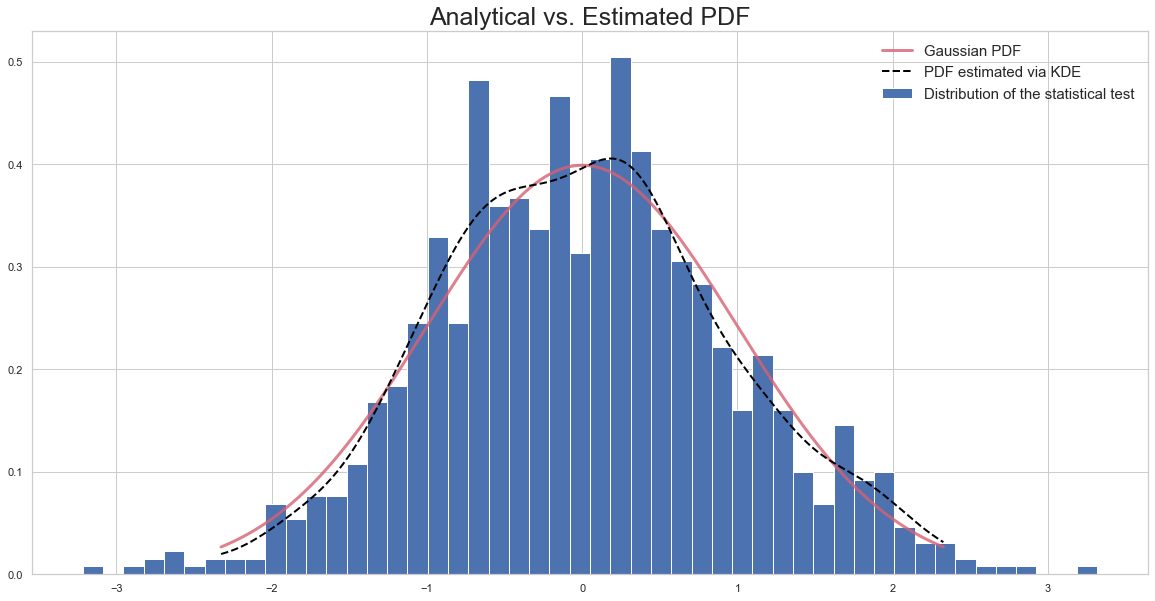

In [31]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=testZ1)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(testZ1,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title('Analytical vs. Estimated PDF', fontsize = 25)

In [32]:
#Compute mean of the statistic Z1
print(np.mean(testZ1))

#Compute variance of the statistic Z1
print(np.var(testZ1))

-0.00012915042018413024
0.9344029206878649


In [33]:
#Calculate the skewness
print(skew(testZ1, axis=0, bias=True))

#Calculate the kurtosis
print(kurtosis(testZ1, axis=0, fisher =  False, bias=True))

0.08833574654563633
3.0945964487529833


In [34]:
#Perform Kolmogorov-Smirnov test for normality 
kstest(testZ1, 'norm')

KstestResult(statistic=0.027477114908192046, pvalue=0.42942761681125563, statistic_location=0.4860182454841536, statistic_sign=1)

Results for group 2 :

Text(0.5, 1.0, 'Analytical vs. Estimated PDF')

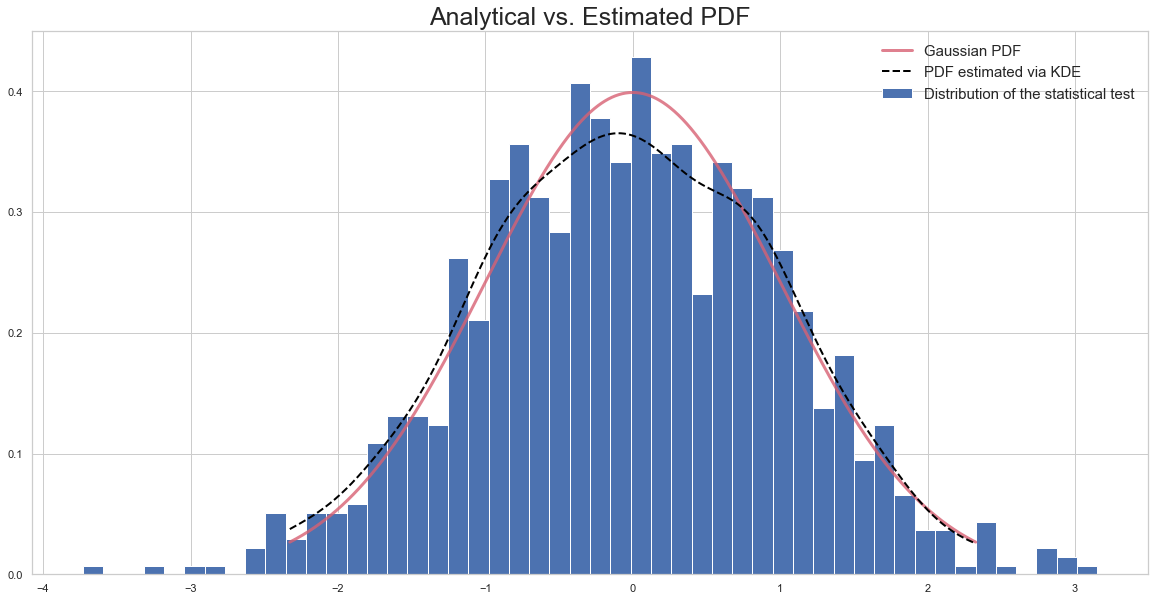

In [35]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=testZ2)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(testZ2,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title('Analytical vs. Estimated PDF', fontsize = 25)

In [36]:
#Compute mean of the statistic Z2
print(np.mean(testZ2))

#Compute variance of the statistic Z2
print(np.var(testZ2))

-0.028494387837350064
1.0537334867789228


In [37]:
#Calculate the skewness
print(skew(testZ2, axis=0, bias=True))

#Calculate the kurtosis
print(kurtosis(testZ2, axis=0, fisher =  False, bias=True))

-0.02228868064164595
2.9861282936508045


In [38]:
#Perform Kolmogorov-Smirnov test
kstest(testZ2, 'norm')

KstestResult(statistic=0.031566885332464156, pvalue=0.26628052375856914, statistic_location=-0.6450940656202149, statistic_sign=1)

In [39]:
#Normality test
stats.normaltest(testZ2)

NormaltestResult(statistic=0.08453202186938176, pvalue=0.9586147446485838)

In [40]:
statsmodels.stats.diagnostic.kstest_normal(testZ2, dist='norm', pvalmethod='table')

(0.023838635442219536, 0.23841898062324968)